In [0]:
import numpy as np 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [317]:
import tensorflow as tf
tf.__version__

'2.2.0-rc3'

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [319]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
training_df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Google_Stock_Price_Train.csv')

In [322]:
training_df.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


## EDA and Data Cleaning

In [323]:
training_df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [324]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [325]:
df1=training_df.copy()
df1.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [326]:
df1['Date']=pd.to_datetime(df1['Date'])
df1.head()

,Date,Open,High,Low,Close,Volume
0,2012-01-03,325.25,332.83,324.97,663.59,"7,380,500"
1,2012-01-04,331.27,333.87,329.08,666.45,"5,749,400"
2,2012-01-05,329.83,330.75,326.89,657.21,"6,590,300"
3,2012-01-06,328.34,328.77,323.68,648.24,"5,405,900"
4,2012-01-09,322.04,322.29,309.46,620.76,"11,688,800"


In [327]:
df1['Date'].describe()

count                    1258
unique                   1258
top       2016-09-08 00:00:00
freq                        1
first     2012-01-03 00:00:00
last      2016-12-30 00:00:00
Name: Date, dtype: object

##### It containes data from 2012-Jan  to 2016-Dec

In [328]:
df1=df1.set_index('Date')
df1.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,325.25,332.83,324.97,663.59,"7,380,500"
2012-01-04,331.27,333.87,329.08,666.45,"5,749,400"
2012-01-05,329.83,330.75,326.89,657.21,"6,590,300"
2012-01-06,328.34,328.77,323.68,648.24,"5,405,900"
2012-01-09,322.04,322.29,309.46,620.76,"11,688,800"


## Setting the frequency of the stock prices to buissness days

In [329]:
df1.asfreq('b')
df1.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,325.25,332.83,324.97,663.59,"7,380,500"
2012-01-04,331.27,333.87,329.08,666.45,"5,749,400"
2012-01-05,329.83,330.75,326.89,657.21,"6,590,300"
2012-01-06,328.34,328.77,323.68,648.24,"5,405,900"
2012-01-09,322.04,322.29,309.46,620.76,"11,688,800"


In [330]:
df1.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

#### Data is completly clean and has no null values

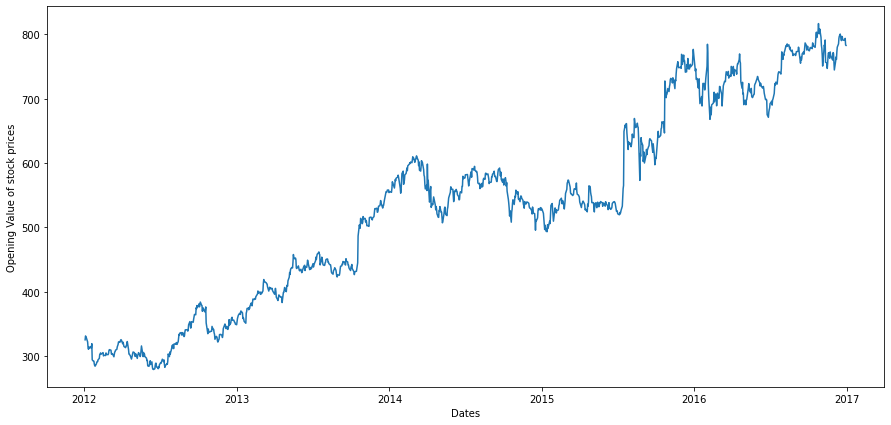

In [331]:
plt.figure(figsize=(15,7))
plt.plot(df1['Open'])
plt.xlabel('Dates')
plt.ylabel('Opening Value of stock prices')
plt.show()

## Preparing Data for RNN Model

In [332]:
training_df.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [333]:
x=training_df['Open']
x=pd.DataFrame(x)
x

,Open
0,325.25
1,331.27
2,329.83
3,328.34
4,322.04
...,...
1253,790.90
1254,790.68
1255,793.70
1256,783.33


### Min-Max Scaler to scale between 0-1

In [0]:
mn=MinMaxScaler()

In [335]:
x=mn.fit_transform(x)
x

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

In [336]:
len(x)

1258

### Data Preprocessing [Creating Time Stamp]

In [0]:
x_train=[]
y_train=[]

In [0]:
for i in range(60, 1258):
    x_train.append(x[i-60:i,0])
    y_train.append(x[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [339]:
y_train

array([0.08627874, 0.08471612, 0.07454052, ..., 0.95725128, 0.93796041,
       0.93688146])

In [340]:
x_train.shape

(1198, 60)

In [341]:
y_train.shape

(1198,)

### Reshaping

In [0]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [343]:
x_train.shape

(1198, 60, 1)

## Building Model

In [0]:
model=Sequential()

In [0]:
model.add(LSTM(units=50,return_sequences = True,input_shape=(60,1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [346]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 60, 50)            10400     
_________________________________________________________________
dropout_24 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_25 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_26 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 50)               

In [0]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [348]:
model.fit(x_train,y_train,batch_size=32,epochs=100)

Epoch 1/100
38/38 [==============================] - 1s 15ms/step - loss: 0.0470
Epoch 2/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0059
Epoch 3/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0055
Epoch 4/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0051
Epoch 5/100
38/38 [==============================] - 1s 15ms/step - loss: 0.0050
Epoch 6/100
38/38 [==============================] - 1s 15ms/step - loss: 0.0046
Epoch 7/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0051
Epoch 8/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0046
Epoch 9/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0049
Epoch 10/100
38/38 [==============================] - 1s 15ms/step - loss: 0.0049
Epoch 11/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0046
Epoch 12/100
38/38 [==============================] - 1s 14ms/step - loss: 0.0036
Epoch 13/100
38/38 [=====

In [349]:
test_df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Google_Stock_Price_Test.csv')
test_df.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [350]:
test_df.shape

(20, 6)

In [351]:
real_stock_price=test_df['Open']
real_stock_price

0     778.81
1     788.36
2     786.08
3     795.26
4     806.40
5     807.86
6     805.00
7     807.14
8     807.48
9     807.08
10    805.81
11    805.12
12    806.91
13    807.25
14    822.30
15    829.62
16    837.81
17    834.71
18    814.66
19    796.86
Name: Open, dtype: float64

In [0]:
df=pd.concat([training_df,test_df],axis=0)

In [353]:
df.shape

(1278, 6)

In [0]:
test=df['Open']

In [355]:
inputs = test[len(df['Open']) - len(test_df['Open']) - 60:].values
inputs

array([779.  , 779.66, 777.71, 786.66, 783.76, 781.22, 781.65, 779.8 ,
       787.85, 798.24, 803.3 , 795.  , 804.9 , 816.68, 806.34, 801.  ,
       808.35, 795.47, 782.89, 778.2 , 767.25, 750.66, 774.5 , 783.4 ,
       779.94, 791.17, 756.54, 755.6 , 746.97, 755.2 , 766.92, 771.37,
       762.61, 772.63, 767.73, 764.26, 760.  , 771.53, 770.07, 757.44,
       744.59, 757.71, 764.73, 761.  , 772.48, 780.  , 785.04, 793.9 ,
       797.4 , 797.34, 800.4 , 790.22, 796.76, 795.84, 792.36, 790.9 ,
       790.68, 793.7 , 783.33, 782.75, 778.81, 788.36, 786.08, 795.26,
       806.4 , 807.86, 805.  , 807.14, 807.48, 807.08, 805.81, 805.12,
       806.91, 807.25, 822.3 , 829.62, 837.81, 834.71, 814.66, 796.86])

In [356]:
inputs = inputs.reshape(-1,1)
inputs

array([[779.  ],
       [779.66],
       [777.71],
       [786.66],
       [783.76],
       [781.22],
       [781.65],
       [779.8 ],
       [787.85],
       [798.24],
       [803.3 ],
       [795.  ],
       [804.9 ],
       [816.68],
       [806.34],
       [801.  ],
       [808.35],
       [795.47],
       [782.89],
       [778.2 ],
       [767.25],
       [750.66],
       [774.5 ],
       [783.4 ],
       [779.94],
       [791.17],
       [756.54],
       [755.6 ],
       [746.97],
       [755.2 ],
       [766.92],
       [771.37],
       [762.61],
       [772.63],
       [767.73],
       [764.26],
       [760.  ],
       [771.53],
       [770.07],
       [757.44],
       [744.59],
       [757.71],
       [764.73],
       [761.  ],
       [772.48],
       [780.  ],
       [785.04],
       [793.9 ],
       [797.4 ],
       [797.34],
       [800.4 ],
       [790.22],
       [796.76],
       [795.84],
       [792.36],
       [790.9 ],
       [790.68],
       [793.7 ],
       [783.33

In [0]:
inputs=mn.transform(inputs)

In [358]:
inputs

array([[0.9299055 ],
       [0.93113327],
       [0.92750577],
       [0.94415507],
       [0.93876032],
       [0.93403527],
       [0.93483518],
       [0.9313937 ],
       [0.94636878],
       [0.96569685],
       [0.97510976],
       [0.95966962],
       [0.97808617],
       [1.        ],
       [0.98076494],
       [0.97083116],
       [0.98450406],
       [0.96054394],
       [0.9371419 ],
       [0.92841729],
       [0.90804747],
       [0.8771858 ],
       [0.92153434],
       [0.93809063],
       [0.93165414],
       [0.95254483],
       [0.88812412],
       [0.88637547],
       [0.87032145],
       [0.88563137],
       [0.90743359],
       [0.91571173],
       [0.89941588],
       [0.91805566],
       [0.9089404 ],
       [0.9024853 ],
       [0.89456061],
       [0.91600938],
       [0.9132934 ],
       [0.88979835],
       [0.86589404],
       [0.89030062],
       [0.90335962],
       [0.89642086],
       [0.91777662],
       [0.93176576],
       [0.94114145],
       [0.957

In [0]:
X_test = []
for i in range(60,80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [360]:
X_test.shape

(20, 60, 1)

In [0]:
predicted_stock_price = model.predict(X_test)

In [362]:
predicted_stock_price = mn.inverse_transform(predicted_stock_price)
predicted_stock_price

array([[775.8781 ],
       [772.9811 ],
       [772.964  ],
       [774.0164 ],
       [776.9248 ],
       [782.3114 ],
       [787.32   ],
       [789.4655 ],
       [790.0271 ],
       [790.1244 ],
       [790.1859 ],
       [790.13416],
       [790.0604 ],
       [790.5933 ],
       [791.4834 ],
       [795.82184],
       [802.27045],
       [809.1666 ],
       [812.97473],
       [809.29694]], dtype=float32)

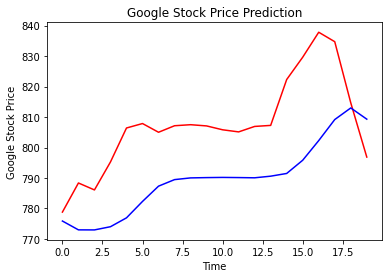

In [363]:
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.show()

In [0]:
from sklearn.metrics import mean_squared_error

In [365]:
mean_squared_error(real_stock_price,predicted_stock_price)

440.10356952266545